In [1]:
# references: 
# https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan
# https://www.kaggle.com/code/heeraldedhia/kmeans-clustering-for-customer-data

import pandas as pd
import numpy as np
import os
import pickle
import shutil
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
import pyreadr
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

Reading the vectorized dataset

In [2]:
with open('../data/vectorized_X.npy', 'rb') as f:
    X = np.load(f)

## 1.0 Using K-Means++ for clustering

#### 1.1 Determining the optimal number of clusters using elbow method

Number of clusters is an hyperparameter for k-Means++ clustering that we need to manually determine. So, we are using 'elbow method' i.e. plottting the performance of model for different number of clusters and looking for the inflection point.

100%|██████████| 28/28 [01:20<00:00,  2.87s/it]


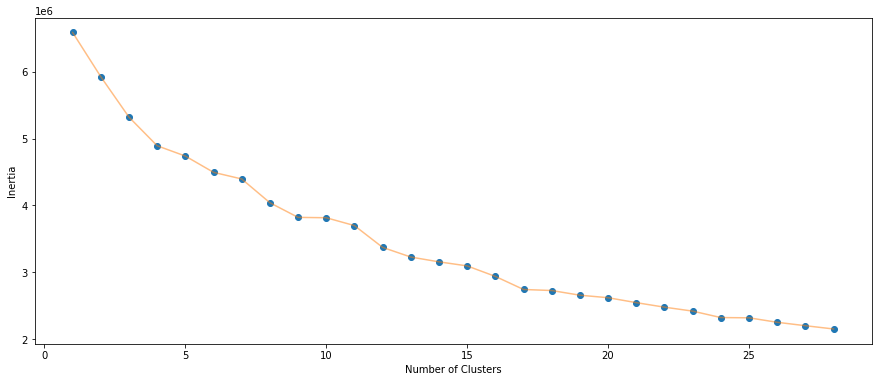

In [4]:
inertia = []
for n in tqdm(range(2 , 30)):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 3 ,max_iter=500, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 29) , inertia , 'o')
plt.plot(np.arange(1 , 29) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

From the above clustering graph we can, we can observe that data can be clustered into 4 clusters, 9 clusters, 12 clusters and lastly 17 clusters.

### 1.2 Implementing PCA to visualize the clusters

Our data has around 30 features, but it cannot be visaualized, so we will project this data into 2 dimensional space using PCA so that we can visualize the clusters formed.

#### For number of clusters = 4 

Text(0.5, 1.0, 'Scatter plot of clusters with number of clusters = 4')

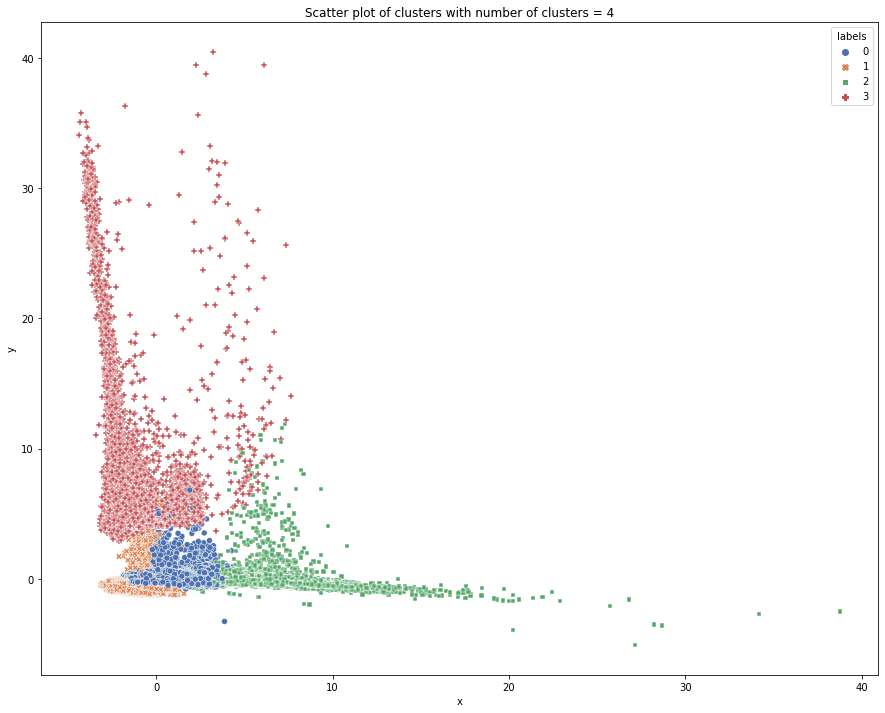

In [3]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 3 ,max_iter=500,
                    tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

pca = PCA(n_components=2)
pca.fit(X)
reduced_data = pca.transform(X)
plt.figure(1, figsize=(15,12))
visual_df = pd.DataFrame( {'x' : reduced_data[:,0], 'y' : reduced_data[:,1], 'labels' : labels1 })
sns.scatterplot(data=visual_df, x='x', y='y', hue='labels', style='labels', palette='deep')
plt.title('Scatter plot of clusters with number of clusters = 4')

In [4]:
algorithm.inertia_

5320214.72249809

#### For number of clusters = 9

Text(0.5, 1.0, 'Scatter plot of clusters with number of clusters = 9')

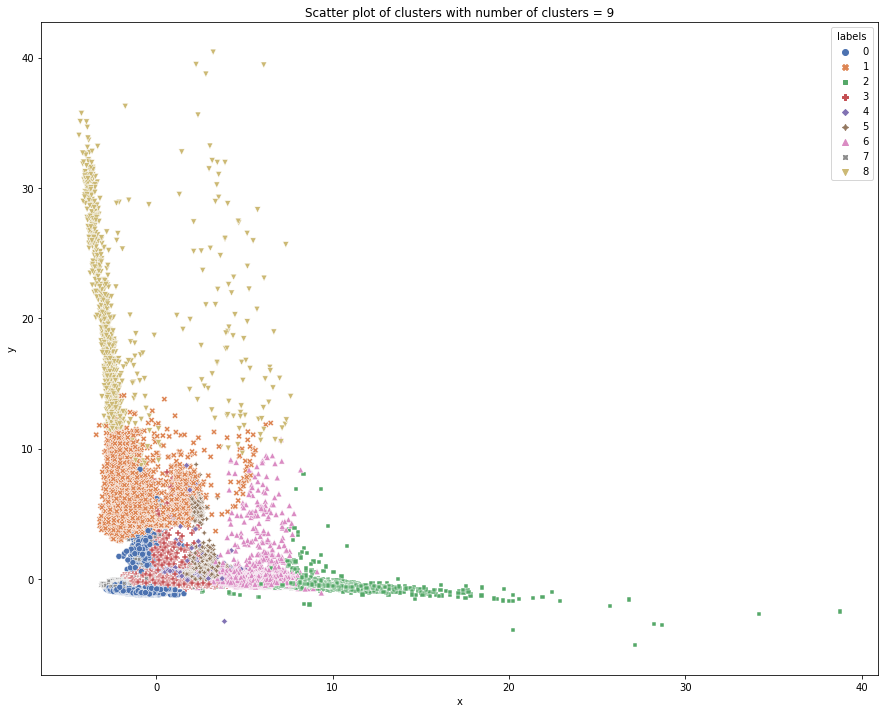

In [ ]:
algorithm = (KMeans(n_clusters = 9 ,init='k-means++', n_init = 3 ,max_iter=500,
                    tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

pca = PCA(n_components=2)
pca.fit(X)
reduced_data = pca.transform(X)
plt.figure(1, figsize=(15,12))
visual_df = pd.DataFrame( {'x' : reduced_data[:,0], 'y' : reduced_data[:,1], 'labels' : labels2 })
sns.scatterplot(data=visual_df, x='x', y='y', hue='labels', style='labels', palette='deep')
plt.title('Scatter plot of clusters with number of clusters = 9')

#### Saving the data and corresponding cluster labels

In [ ]:
temp_df = pd.read_csv('../data/X_train.csv')
temp_df['cluster_label'] = labels2 
#temp_df.to_csv('.../data/X_train_labelled.csv', index=None)

## 2.0 Using DBSCAN

Now, that we have clustered data using k-Means, let's also apply DBSCAN and check for the clusters formed. 

### 2.1 Determining the hyperparameter 'eps' for DBSCAN


DBSCAN needs to be tuned for the hyper-paremeter 'eps' which is basically the radius it uses to determine the nearest neighbours. Let us determined the radius using below method:

1. Find the avergage nearest neighbour distance for each of the datapoint.
2. Find the sort the nearest neighbour in ascending order of magnitude. 
3. Look for the 'inflection point' ie. the point from which the average nearest neighbour distance suddenly increases.

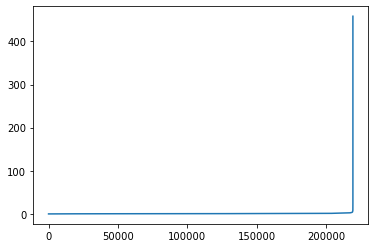

In [9]:
# reference : 
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbcneigh = NearestNeighbors(n_neighbors=5)
neigh = NearestNeighbors(n_neighbors=50)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
percentiles = []
for i in range(1,100,10):
    percentiles.append(np.percentile(distances, i))
    
percentiles

In [ ]:
percentiles1 = []
for i in np.linspace(98.,100,100):
    percentiles1.append(np.percentile(distances, i))
    
plt.plot(percentiles1)

From the above analysis we discovered that, the nearest neighbour distance suddenly increases after radius = 2.0 So we will use eps  2.0

In [ ]:
dbscan = DBSCAN(eps=2.0, min_samples=1000)
dbscan.fit(X)

#### 2.2 Using PCA to visualize the clusters formed

In [ ]:
dbscan_labels = dbscan.labels_

pca = PCA(n_components=2)
pca.fit(X)
reduced_data = pca.transform(X)
plt.figure(1, figsize=(15,12))
visual_df = pd.DataFrame( {'x' : reduced_data[:,0], 'y' : reduced_data[:,1], 'labels' : dbscan_labels })
sns.scatterplot(data=visual_df, x='x', y='y', hue='labels', style='labels', palette='deep')
plt.title('Clustering using DBSCAN')

## Conclusion:

1. The ideal number of clusters as per K-Means++ is 4. <br>
2. The ideal number of clusters as per DBSCAN is 10. <br>
3. The clusters obtained in K-Means++ are better than the ones obtained in DBSCAN. <br>

### K-Means:
#### Pros:
1. Clusters the data quite well. 
2. The clusters formed seem to equally divide the data among different clusters with 'k-means++' initialization strategy.
3. Is very fast as compared to other clustering algorithms. so can be initialized multiple times. 

#### Cons: 
1. We need to explicily determine the total number of clusters. It is one of the hyperparameters for k-Means++.
2. There is a trade off between lower number of clusters and the amount of information that we are okay to 'let go'/dropped. 
3. Might Fails to group/cluster data well when the data has varying density.

### DBSCAN:
#### Pros:
1. Clusters data quite well even if the data is of varying density.
2. No need to explicitly specify the number of clusters. It determines the number of clusters on its own based on the data distribution and density.

#### Cons:
1. Is very slow as compared to k-Means. 
2. The clusters formed are created based on density and nearest neighbours. So, they might not be good enough. 